In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Lasso
import warnings

warnings.filterwarnings('ignore')

In [4]:
house_price_df=pd.read_csv('House_Price_Data.csv.csv') # Dataframe
y=house_price_df['SalePrice']

In [5]:
na_df=pd.DataFrame({'col_name':house_price_df.columns,'na_count':house_price_df.isnull().sum(),
              'na_pc':house_price_df.isnull().sum()/house_price_df.shape[0]*100})

cols_50grt_nas=list(na_df[na_df['na_pc']>50]['col_name'].index)

In [6]:
cols_unique_same=[]
for col in house_price_df.columns:
    if house_price_df[col].nunique()==1 or house_price_df[col].nunique()==house_price_df.shape[0]:
        cols_unique_same.append(col)
        
cols_unique_same

cols_to_drop=cols_50grt_nas+cols_unique_same

cols_to_drop.append('SalePrice')

house_price_df.drop(columns=cols_to_drop,inplace=True)

In [7]:
num_cols=[col for col in house_price_df.columns if house_price_df[col].dtype!='object']

cat_cols=[col for col in house_price_df.columns if house_price_df[col].dtype=='object']

In [8]:
X_train,X_test,y_train,y_test=train_test_split(house_price_df,y,test_size=0.2,random_state=42)

In [9]:
for col in num_cols:
    X_train[col]=X_train[col].fillna(X_train[col].mean())
    X_test[col]=X_test[col].fillna(X_train[col].mean())
    
for col in cat_cols:
    X_train[col]=X_train[col].fillna(X_train[col].mode()[0])
    X_test[col]=X_test[col].fillna(X_train[col].mode()[0])

In [10]:
scaler=StandardScaler()

for col in num_cols:
    X_train[col]=scaler.fit_transform(np.array(X_train[col]).reshape(-1,1))
    X_test[col]=scaler.transform(np.array(X_test[col]).reshape(-1,1))

In [11]:
oe_train=pd.get_dummies(X_train[cat_cols])
oe_test=pd.get_dummies(X_test[cat_cols])

In [12]:
oe_train_final,oe_test_final=oe_train.align(oe_test,join='inner',axis=1,fill_value=0)

In [13]:
X_train_final=pd.concat([X_train[num_cols],oe_train_final],axis=1)
X_test_final=pd.concat([X_test[num_cols],oe_test_final],axis=1)

In [14]:
linreg=LinearRegression()
linreg.fit(X_train_final,y_train)

pred=linreg.predict(X_test_final)

r2_score(y_test,pred)

print('Test Score',linreg.score(X_train_final,y_train))

print('Test Score',linreg.score(X_test_final,y_test))

Test Score 0.9081050305872594
Test Score 0.874692551277254


In [15]:

lasso_reg=Lasso(alpha=3)

lasso_reg.fit(X_train_final,y_train)

coeff=lasso_reg.coef_
len(coeff[coeff==0]) #where the coefficients become zero

19

In [25]:
coeff_df=pd.DataFrame()
for alpha in range(1,5):
    
    lasso_reg=Lasso(alpha)
    lasso_reg.fit(X_train_final,y_train)
    coeff=lasso_reg.coef_
    coeff_df['alpha=',alpha]=coeff

coeff_df.set_index(X_train_final.columns)
#zero_values_df=pd.DataFrame({'alpha_value=1':alpha,'zero_values':len(coeff[coeff==0])})

for col in coeff_df.columns:
    print(len(coeff_df[coeff_df[col]==0]))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


15
18
19
23


In [17]:
# stochastic gradient descent regressor
from sklearn.linear_model import SGDRegressor
sgd_reg=SGDRegressor(verbose=4) # the other parameters like verbose are penalty,loss,alpha,etc all these are called as hyper-parameters
#hyper-parameters: parameters like b1,b2 are not in our hand and we znt control them, but the hyper parameters are the parameters that we can control thsts why they are called as HYPER parameters
sgd_reg.fit(X_train_final,y_train)
pred=sgd_reg.predict(X_test_final)
r2_score(y_test,pred)

-- Epoch 1
Norm: 48908.98, NNZs: 237, Bias: 8076.453762, T: 1168, Avg. loss: 946056934.201719
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 56478.12, NNZs: 237, Bias: 9080.710741, T: 2336, Avg. loss: 704894077.328251
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 57708.68, NNZs: 237, Bias: 9281.227196, T: 3504, Avg. loss: 569140078.965942
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 62113.46, NNZs: 237, Bias: 9521.776567, T: 4672, Avg. loss: 538492165.503983
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 61236.78, NNZs: 237, Bias: 9595.393361, T: 5840, Avg. loss: 486977988.530244
Total training time: 0.01 seconds.


0.8132706940795855

In [18]:
sgd_reg.score(X_train_final,y_train)
sgd_reg.score(X_test_final,y_test)

0.8132706940795855

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF is a measure of multicollinearity

vif=pd.DataFrame()
vif["VIF Factor"]=[variance_inflation_factor(X_train_final.values,i) for i in range(X_train_final.shape[1])]
vif["VIF Features"] =X_train_final.columns
vif

,VIF Factor,VIF Features
0,51.544523,MSSubClass
1,2.617734,LotFrontage
2,4.484244,LotArea
3,5.442198,OverallQual
4,2.549449,OverallCond
5,14.883646,YearBuilt
6,3.905412,YearRemodAdd
7,3.228481,MasVnrArea
8,inf,BsmtFinSF1
9,inf,BsmtFinSF2


In [42]:
n_estimates=list(range(20,200,20))

from sklearn.ensemble import RandomForestRegressor

accuracy=[]
for val in n_estimates:
    rndm_frt_rgr=RandomForestRegressor(n_estimators=val)
    rndm_frt_rgr.fit(X_train_final,y_train)
    accuracy.append(rndm_frt_rgr.score(X_train_final,y_train))
accuracy


[0.9642290830643216,
 0.9771364732480315,
 0.9769340799849785,
 0.9787094611271959,
 0.97853436218907,
 0.980558933242961,
 0.9797370024480326,
 0.9797512536161459,
 0.9780117181253596]

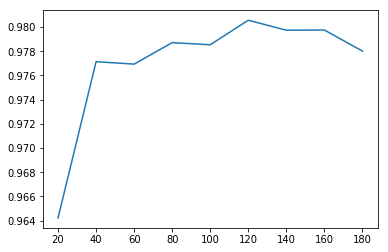

In [44]:
from matplotlib.pyplot import plot
plot(n_estimates,accuracy)

In [45]:
param_dict={'n_estimators':[50,60,70,100],
            'min_samples_split':[4,7,9],
            'max_depth':[7,8,9],
           'max_features':['auto', 'sqrt', 'log2']}
from  sklearn.model_selection import GridSearchCV
gcv= GridSearchCV(rndm_frt_rgr,param_grid=param_dict,cv=5,verbose=5)
gcv.fit(X_train_final,y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50, score=0.8418122559276591, total=   0.8s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50, score=0.7492836036125066, total=   0.8s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50, score=0.8028990821156552, total=   0.8s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50, score=0.858376957492205, total=   0.7s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=50, score=0.8630638490499738, total=   0.7s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60, score=0.8581566872400128, total=   1.0s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60, score=0.756149158292814, total=   1.0s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60, score=0.7960833377724482, total=   1.0s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60, score=0.8609521089598432, total=   0.9s
[CV] max_depth=7, max_features=auto, min_samples_split=4, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samp

[CV]  max_depth=7, max_features=auto, min_samples_split=9, n_estimators=60, score=0.792549529683839, total=   0.9s
[CV] max_depth=7, max_features=auto, min_samples_split=9, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samples_split=9, n_estimators=60, score=0.8649731064774719, total=   0.9s
[CV] max_depth=7, max_features=auto, min_samples_split=9, n_estimators=60 
[CV]  max_depth=7, max_features=auto, min_samples_split=9, n_estimators=60, score=0.8636129670049337, total=   0.9s
[CV] max_depth=7, max_features=auto, min_samples_split=9, n_estimators=70 
[CV]  max_depth=7, max_features=auto, min_samples_split=9, n_estimators=70, score=0.8489529831932391, total=   1.0s
[CV] max_depth=7, max_features=auto, min_samples_split=9, n_estimators=70 
[CV]  max_depth=7, max_features=auto, min_samples_split=9, n_estimators=70, score=0.7537526495801183, total=   1.0s
[CV] max_depth=7, max_features=auto, min_samples_split=9, n_estimators=70 
[CV]  max_depth=7, max_features=auto, min_samp

[CV]  max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70, score=0.806951832696699, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70 
[CV]  max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70, score=0.8028052235970222, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70 
[CV]  max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70, score=0.7598044679110112, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70 
[CV]  max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70, score=0.8294652253013908, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70 
[CV]  max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=70, score=0.8465710792228264, total=   0.1s
[CV] max_depth=7, max_features=sqrt, min_samples_split=7, n_estimators=100 
[CV]  max_depth=7, max_features=sqrt, min_sam

[CV]  max_depth=7, max_features=log2, min_samples_split=4, n_estimators=70, score=0.7808424721110279, total=   0.0s
[CV] max_depth=7, max_features=log2, min_samples_split=4, n_estimators=70 
[CV]  max_depth=7, max_features=log2, min_samples_split=4, n_estimators=70, score=0.8124042798758215, total=   0.0s
[CV] max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100, score=0.7767719199239174, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100, score=0.7747264548331095, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100, score=0.718535669811482, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=4, n_estimators=100 
[CV]  max_depth=7, max_features=log2, m

[CV]  max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100, score=0.7875289862769567, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100, score=0.7034664494656273, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100, score=0.7826581607492107, total=   0.1s
[CV] max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100 
[CV]  max_depth=7, max_features=log2, min_samples_split=9, n_estimators=100, score=0.8005405873989583, total=   0.1s
[CV] max_depth=8, max_features=auto, min_samples_split=4, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_split=4, n_estimators=50, score=0.8771958021684572, total=   0.8s
[CV] max_depth=8, max_features=auto, min_samples_split=4, n_estimators=50 
[CV]  max_depth=8, max_features=auto, 

[CV]  max_depth=8, max_features=auto, min_samples_split=7, n_estimators=100, score=0.8621688196306513, total=   1.7s
[CV] max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50, score=0.8556506538234473, total=   0.8s
[CV] max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50, score=0.7753422365075271, total=   0.8s
[CV] max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50, score=0.8025833259187777, total=   0.8s
[CV] max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50, score=0.8660896769077185, total=   0.8s
[CV] max_depth=8, max_features=auto, min_samples_split=9, n_estimators=50 
[CV]  max_depth=8, max_features=auto, min_sa

[CV]  max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=50, score=0.8254374145261573, total=   0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=50 
[CV]  max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=50, score=0.8485862037059408, total=   0.0s
[CV] max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60 
[CV]  max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60, score=0.8290995219446028, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60 
[CV]  max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60, score=0.821977871070781, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60 
[CV]  max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60, score=0.7760557413172492, total=   0.1s
[CV] max_depth=8, max_features=sqrt, min_samples_split=7, n_estimators=60 
[CV]  max_depth=8, max_features=sqrt, min_samp

[CV]  max_depth=8, max_features=log2, min_samples_split=4, n_estimators=60, score=0.7428842931022841, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_split=4, n_estimators=60 
[CV]  max_depth=8, max_features=log2, min_samples_split=4, n_estimators=60, score=0.8179595806048202, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_split=4, n_estimators=60 
[CV]  max_depth=8, max_features=log2, min_samples_split=4, n_estimators=60, score=0.8213885415790996, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_split=4, n_estimators=70 
[CV]  max_depth=8, max_features=log2, min_samples_split=4, n_estimators=70, score=0.7712211904749523, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_split=4, n_estimators=70 
[CV]  max_depth=8, max_features=log2, min_samples_split=4, n_estimators=70, score=0.8086502814113764, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_split=4, n_estimators=70 
[CV]  max_depth=8, max_features=log2, min_sam

[CV]  max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70, score=0.8014479879259645, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70 
[CV]  max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70, score=0.7350233079911628, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70 
[CV]  max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70, score=0.781608845578064, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70 
[CV]  max_depth=8, max_features=log2, min_samples_split=9, n_estimators=70, score=0.8153027324825977, total=   0.0s
[CV] max_depth=8, max_features=log2, min_samples_split=9, n_estimators=100 
[CV]  max_depth=8, max_features=log2, min_samples_split=9, n_estimators=100, score=0.7725430815773392, total=   0.1s
[CV] max_depth=8, max_features=log2, min_samples_split=9, n_estimators=100 
[CV]  max_depth=8, max_features=log2, min_s

[CV]  max_depth=9, max_features=auto, min_samples_split=7, n_estimators=70, score=0.8718869381515115, total=   1.3s
[CV] max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100, score=0.863727885357011, total=   1.9s
[CV] max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100, score=0.7660703762172283, total=   1.8s
[CV] max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100, score=0.7969653554609141, total=   1.8s
[CV] max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100, score=0.8776398834324337, total=   1.8s
[CV] max_depth=9, max_features=auto, min_samples_split=7, n_estimators=100 
[CV]  max_depth=9, max_features=auto,

[CV]  max_depth=9, max_features=sqrt, min_samples_split=4, n_estimators=100, score=0.7928953884629315, total=   0.2s
[CV] max_depth=9, max_features=sqrt, min_samples_split=4, n_estimators=100 
[CV]  max_depth=9, max_features=sqrt, min_samples_split=4, n_estimators=100, score=0.8529814664965989, total=   0.2s
[CV] max_depth=9, max_features=sqrt, min_samples_split=4, n_estimators=100 
[CV]  max_depth=9, max_features=sqrt, min_samples_split=4, n_estimators=100, score=0.8684092408826374, total=   0.2s
[CV] max_depth=9, max_features=sqrt, min_samples_split=7, n_estimators=50 
[CV]  max_depth=9, max_features=sqrt, min_samples_split=7, n_estimators=50, score=0.8331487402678371, total=   0.1s
[CV] max_depth=9, max_features=sqrt, min_samples_split=7, n_estimators=50 
[CV]  max_depth=9, max_features=sqrt, min_samples_split=7, n_estimators=50, score=0.8176314574992544, total=   0.0s
[CV] max_depth=9, max_features=sqrt, min_samples_split=7, n_estimators=50 
[CV]  max_depth=9, max_features=sqrt, mi

[CV]  max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50, score=0.8006552829577112, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50, score=0.7357341380610354, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50, score=0.8194295708957364, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50 
[CV]  max_depth=9, max_features=log2, min_samples_split=4, n_estimators=50, score=0.8292358368374014, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=4, n_estimators=60 
[CV]  max_depth=9, max_features=log2, min_samples_split=4, n_estimators=60, score=0.7920434806241193, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=4, n_estimators=60 
[CV]  max_depth=9, max_features=log2, min_sam

[CV]  max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60, score=0.7756320247391796, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60 
[CV]  max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60, score=0.8061802590289798, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60 
[CV]  max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60, score=0.7390920266617811, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60 
[CV]  max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60, score=0.8108469305711826, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60 
[CV]  max_depth=9, max_features=log2, min_samples_split=9, n_estimators=60, score=0.8186646429013578, total=   0.0s
[CV] max_depth=9, max_features=log2, min_samples_split=9, n_estimators=70 
[CV]  max_depth=9, max_features=log2, min_sam

[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  5.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60, 70, 100], 'min_samples_split': [4, 7, 9], 'max_depth': [7, 8, 9], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [46]:
gcv.best_params_
gcv.predict(X_test_final)
gcv.score(X_train_final,y_train)

# assignment explore the library HyperOpt

0.9637813238444402

In [48]:
# hyper parameter tuning
param_dict={'n_estimators':[50,60,70,100],
            'min_samples_split':[4,7,9],
            'max_depth':[7,8,9],
           'max_features':['auto', 'sqrt', 'log2']}
from  sklearn.model_selection import RandomizedSearchCV
rcv= RandomizedSearchCV(rndm_frt_rgr,param_distributions=param_dict,cv=5,n_iter=9,verbose=5)
rcv.fit(X_train_final,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7, score=0.8638810511837945, total=   1.0s
[CV] n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7 
[CV]  n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7, score=0.7398164508453682, total=   1.0s
[CV] n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7, score=0.8059575136499703, total=   1.0s
[CV] n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[CV]  n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7, score=0.8672507748450531, total=   1.0s
[CV] n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s


[CV]  n_estimators=60, min_samples_split=4, max_features=auto, max_depth=7, score=0.8586634428155995, total=   1.0s
[CV] n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8, score=0.8699107129692167, total=   0.9s
[CV] n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8, score=0.7631537540106137, total=   0.9s
[CV] n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8, score=0.7911393038704584, total=   0.9s
[CV] n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8, score=0.8709955705534106, total=   0.9s
[CV] n_estimators=50, min_samples_split=4, max_features=auto, max_depth=8 
[CV]  n_estimators=50, min_samples_split=4, m

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   37.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=180, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=9, n_jobs=None,
          param_distributions={'n_estimators': [50, 60, 70, 100], 'min_samples_split': [4, 7, 9], 'max_depth': [7, 8, 9], 'max_features': ['auto', 'sqrt', 'log2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [49]:
rcv.best_params_
rcv.predict(X_test_final)
rcv.score(X_train_final,y_train)

0.9665727779547011

In [ ]:
# 01-03-2021 assignment : do try the gradient boost model to all the available datasets(gradiet boost regressor for datasets with op varible being continuous and GBoost Classifier for classification prblm).also do the hyper parameter tuning

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
grd_bst_rgr=GradientBoostingRegressor()

grd_bst_rgr.fit(X_train_final,y_train)
grd_bst_rgr.predict(X_test_final)
grd_bst_rgr.score(X_train_final,y_train)
grd_bst_rgr.score(X_test_final,y_test)

0.910002956386934

In [52]:
from  sklearn.model_selection import RandomizedSearchCV
param_dict_gd_br={'n_estimators':[50,60,70,100],
            'learning_rate':[0.1,0.12,0.14,0.16],
            'criterion':['friedman_mse','mse','mae'],
           'subsample':[0.8,0.9,1],
             'min_samples_split':[2,3,4]}
rcv_grd_rgr= RandomizedSearchCV(grd_bst_rgr,param_distributions=param_dict_gd_br,cv=5,n_iter=9,verbose=5)
rcv_grd_rgr.fit(X_train_final,y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse, score=0.859765653146023, total=   0.8s
[CV] subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse, score=0.7397579974492454, total=   0.8s
[CV] subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse, score=0.8264665638336589, total=   0.9s
[CV] subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse, score=0.8882523677597095, total=   0.9s
[CV] subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.7s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=100, min_samples_split=3, learning_rate=0.16, criterion=friedman_mse, score=0.8953597008264222, total=   0.8s
[CV] subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse 
[CV]  subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse, score=0.8651223006307949, total=   0.4s
[CV] subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse 
[CV]  subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse, score=0.8090141661170005, total=   0.4s
[CV] subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse 
[CV]  subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse, score=0.843784136288477, total=   0.4s
[CV] subsample=1, n_estimators=60, min_samples_split=4, learning_rate=0.16, criterion=friedman_mse 
[CV]  subsample=1, n_estimators=60

[CV]  subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse, score=0.8614673707773889, total=   0.4s
[CV] subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse 
[CV]  subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse, score=0.745151647579598, total=   0.4s
[CV] subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse 
[CV]  subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse, score=0.8516772091624627, total=   0.4s
[CV] subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse 
[CV]  subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse, score=0.8785807818556561, total=   0.4s
[CV] subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse 
[CV]  subsample=0.8, n_estimators=50, min_samples_split=3, learning_rate=0.14, criterion=mse,

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=9, n_jobs=None,
          param_distributions={'n_estimators': [50, 60, 70, 100], 'learning_rate': [0.1, 0.12, 0.14, 0.16], 'criterion': ['friedman_mse', 'mse', 'mae'], 'subsample': [0.8, 0.9, 1], 'min_samples_split': [2, 3, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [53]:
rcv_grd_rgr.score(X_train_final,y_train)
rcv_grd_rgr.score(X_test_final,y_test)
rcv_grd_rgr.best_params_

{'subsample': 0.8,
 'n_estimators': 100,
 'min_samples_split': 2,
 'learning_rate': 0.12,
 'criterion': 'mae'}